In [5]:
from influxdb import InfluxDBClient
import datetime
import copy
import urllib3, shutil
import pandas as pd
import numpy as np
from multiprocessing import Pool
import pytz
import json
from tqdm import tqdm_notebook
import requests

import warnings
warnings.filterwarnings("ignore")

#import tkinter
import matplotlib
%matplotlib inline
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

In [3]:
influx_client = InfluxDBClient('10.10.2.8', 8086, 'root',password='root''mydb')
influx_client.switch_database('mydb')

In [399]:
influx_client.query("SHOW TAG KEYS FROM deribit_tick_trade")

ResultSet({'('deribit_tick_trade', None)': [{'tagKey': 'liquidation'}, {'tagKey': 'side'}, {'tagKey': 'symbol'}, {'tagKey': 'tick_direction'}]})

In [396]:
#pd.DataFrame(influx_client.query("SHOW TAG VALUES FROM deribit_1min_trade WITH KEY = symbol").get_points()).query("value=='XBTZ19'")
pd.DataFrame(influx_client.query("SHOW TAG VALUES FROM deribit_1min_trade WITH KEY = symbol").get_points())

key          value
0  symbol    BTC-27DEC19
1  symbol    BTC-27MAR20
2  symbol  BTC-PERPETUAL

In [283]:
#influx_client.query('SELECT * INTO mydb..bitmex_tick_quote FROM BitMex_Liquidation_test..quote GROUP BY *')

ResultSet({'('result', None)': [{'time': '1970-01-01T00:00:00Z', 'written': 2010793588}]})

In [388]:
influx_client.query("SELECT * FROM bitmex_tick_trade ORDER BY time desc LIMIT 1")

ResultSet({'('bitmex_tick_trade', None)': [{'tickDirection': 'ZeroPlusTick', 'time': '2019-11-12T23:59:59.998537984Z', 'homeNotional': 0.028917, 'side': 'Buy', 'foreignNotional': 255, 'size': 255, 'grossValue': 2891700, 'trdMatchID': '61a2349f-0686-de0d-79b2-dde99f007743', 'price': 8818, 'symbol': 'XBTUSD'}]})

In [32]:
influx_client.get_list_database()

[{'name': '_internal'},
 {'name': 'mydb'},
 {'name': 'tutorial'},
 {'name': 'BitMex_Liquidation_test'}]

In [390]:
influx_client.get_list_measurements()

[{'name': 'BTC_Spot_deribit'},
 {'name': 'bitmexOI'},
 {'name': 'bitmex_1min_trade'},
 {'name': 'bitmex_tick_quote'},
 {'name': 'bitmex_tick_trade'},
 {'name': 'block_stats'},
 {'name': 'bloomberg'},
 {'name': 'bloombergHTD'},
 {'name': 'deribit_1min_trade'},
 {'name': 'deribit_tick_trade'},
 {'name': 'instrument'},
 {'name': 'instrument2'},
 {'name': 'lastQuote'},
 {'name': 'liquidation'},
 {'name': 'mempoolinfo'},
 {'name': 'mininginfo'},
 {'name': 'quote'}]

In [394]:
influx_client.query("SELECT * FROM bitmex_1min_trade ORDER BY time LIMIT 1")

ResultSet({'('bitmex_1min_trade', None)': [{'high': 3693.5, 'homeNotional': 429.80036984, 'low': 3689, 'foreignNotional': 1586756, 'close': 3693, 'open': 3689, 'vwap': 3691.9442, 'volume': 1586756, 'turnover': 42980036984, 'time': '2019-01-01T00:00:00Z', 'lastSize': 20, 'trades': 463, 'symbol': 'XBTUSD'}]})

In [378]:
#influx_client.delete_series(measurement='quote')
#influx_client.query("DROP MEASUREMENT quote")

ResultSet({})

### Bitmex Tick Trade

In [159]:
#client=bitmex.bitmex(api_key='_41oz5mPfxSgSiKyiwJZSCka', 
#                     api_secret='98H_yy0sjB60fXzwtd21dr2mtfaEyRRQxOnZ55pBCmgOI5hG')

#client = bitmex.bitmex()
#client.Trade.Trade_getBucketed(symbol="XBTUSD", binSize="5m", count=10, startTime=datetime.datetime(2018, 1, 1), endT).result()
# result = client.Trade.Trade_get(symbol="XBTUSD", 
#                                 reverse=False, 
#                                 count=5000).result()

In [ ]:
# fix
def load_trade(results, pool):
    """
    This function is to transform a single point into the JSON format InfluxDB uses.

    :param results: One single point with dictionary data structure

    """
    body = {
        'measurement': 'trade',

        'tags': {'symbol': results['symbol'],
                 'side': results['side'],
                 'tickDirection': results['tickDirection']},
        # no matter replace D by T or space, influxDB will change it to T anyway.
        # Nanosec is stored by default in Bitmex.
        'time': results['timestamp'].replace('D', 'T')
    }

    # remove used columns
    del results['symbol'], results['timestamp'], results['side'], results['tickDirection']

    body['fields'] = results
    # Type coercion in case it is sometimes integer or float with confilcts
    body['fields']['price'] = float(body['fields']['price'])
    body['fields']['foreignNotional'] = float(body['fields']['foreignNotional'])
    body['fields']['homeNotional'] = float(body['fields']['homeNotional'])

    for member in list(body['fields'].keys()):  # list is to avoid iteration runtime error caused by removing keys
        if pd.isnull(body['fields'][member]):
            del body['fields'][member]  # remove field columns with nan

    pool.append(body)
    if len(pool) > 10000:
        influx_client.write_points(pool)
        pool.clear()
    return pool

In [ ]:
start = datetime.datetime.strptime("20181109", "%Y%m%d")
end = datetime.datetime.strptime("20191024", "%Y%m%d")  # the end date is not included, so +1

date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end - start).days)]
pool = []
for date in date_generated:
    date = date.strftime("%Y%m%d")
    url = 'https://s3-eu-west-1.amazonaws.com/public.bitmex.com/data/trade/' + str(date) + '.csv.gz'
    c = urllib3.PoolManager()
    filename = "day_trade.csv.gz"
    with c.request('Get', url, preload_content=False) as res, open(filename, 'wb') as out_file:
        shutil.copyfileobj(res, out_file)

    record = pd.read_csv('day_trade.csv.gz').to_dict(orient='record')
    for chunk in record:
        pool = load_trade(chunk, pool)

In [566]:
influx_client.get_list_measurements()

[{'name': 'BTC_Spot_BM'},
 {'name': 'BTC_Spot_deribit'},
 {'name': 'instrument'},
 {'name': 'liquidation'},
 {'name': 'quote'},
 {'name': 'trade'}]

In [507]:
#influx_client.delete_series(measurement='trade')

In [ ]:
#influx_client.query('SELECT * FROM trade')

In [380]:
influx_client.query('SELECT MAX(created_at) FROM trade')

ResultSet({})

In [269]:
start = list(influx_client.query("SELECT * FROM trade ORDER BY time desc LIMIT 1").get_points())[0]['time']
start = pd.to_datetime(start).date() + datetime.timedelta(days=1)
#start = datetime.datetime.strftime(start, "%Y%m%d")

end = datetime.datetime.utcnow().date()
#end = datetime.datetime.strftime(end, "%Y%m%d")
[start + datetime.timedelta(days=x) for x in range(0, (end - start).days)]

[datetime.date(2019, 11, 13)]

In [201]:
influx_client.query("SELECT * FROM bitmex_tick_trade where symbol = '.BXBT' ORDER BY time desc LIMIT 1")

ResultSet({})

### Bitmex Tick Quote

In [430]:
def load_quote(results, pool):
    body = {}
    body['measurement'] = 'quote'
    body['tags'] = {'symbol': results['symbol']}
    body['time'] = results['timestamp'].replace('D', 'T')

    del results['symbol'], results['timestamp']

    body['fields'] = results

    for member in list(body['fields'].keys()):  # list is to avoid iteration runtime error caused by removing keys
        if pd.isnull(body['fields'][member]):
            del body['fields'][member]
        else:
            body['fields'][member] = float(body['fields'][member])

    if len(body['fields']) != 0:
        pool.append(body)
        if len(pool) > 10000:
            influx_client.write_points(pool)
            pool.clear()
    return pool

In [ ]:
start = datetime.datetime.strptime("20141122", "%Y%m%d")
end = datetime.datetime.strptime("20190929", "%Y%m%d")  # the end date is not included, so +1
date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end - start).days)]
pool = []
for date in np.flip(date_generated):
    date = date.strftime("%Y%m%d")
    url = 'https://s3-eu-west-1.amazonaws.com/public.bitmex.com/data/quote/' + str(date) + '.csv.gz'
    c = urllib3.PoolManager()
    filename = "day_quote.csv.gz"
    with c.request('Get', url, preload_content=False) as res, open(filename, 'wb') as out_file:
        shutil.copyfileobj(res, out_file)
    # Do it in multiprocessing
    record = pd.read_csv('day_quote.csv.gz').to_dict(orient='record')
    for chunk in record:
        pool = load_quote(chunk, pool)

In [895]:
record = pd.read_csv("./influxdb/quote1/day_quote.csv.gz").to_dict(orient='record')

In [717]:
#influx_client.delete_series(measurement='quote')

In [135]:
influx_client.query("SELECT * FROM bitmex_tick_quote ORDER BY time desc LIMIT 1")

ResultSet({'('bitmex_tick_quote', None)': [{'time': '2019-11-17T23:59:59.930566144Z', 'askPrice': 8506.5, 'askSize': 637693, 'bidPrice': 8506, 'bidSize': 1423877, 'symbol': 'XBTUSD'}]})

### Bitmex 1-min bar trade

In [ ]:
#https://testnet.bitmex.com/api/explorer/
import bitmex
client = bitmex.bitmex()
client.Trade.Trade_get(symbol='XBTZ19', startTime=datetime.datetime(2019, 10, 25), endTime=datetime.datetime(2019, 10, 26)).result()

In [ ]:
import requests
start = datetime.datetime.strptime("20190101", "%Y%m%d")
end = datetime.datetime.strptime("20190102", "%Y%m%d")  # the end date is not included, so +1
symbol ='XBTUSD'

baseURI = "https://www.bitmex.com/api/v1"
endpoint = "/trade/bucketed"
params = {'binSize': '1m', 'symbol': symbol, 'count' : 300, 'startTime' : start, 'endTime': end }
r = requests.get(baseURI + endpoint, params = params)
r = r.json()
r

In [ ]:
import requests
baseURI = "https://www.bitmex.com/api/v1"
endpoint = "/trade/bucketed"
while latestDB < bitmexLatest:
    params = {'binSize': '1m', 'symbol': symbol, 'count' : 300, 'startTime' : latestDB}
    r = requests.get(baseURI + endpoint, params = params)
    r = r.json()
    writeToDB(r)
    latestDB = r[-1]['timestamp']
    time.sleep(1)

In [25]:
from influxdb import InfluxDBClient
import datetime
import urllib3, shutil
import pandas as pd
from collections import defaultdict
import time
import copy
import numpy as np
import json
import requests
import warnings
warnings.filterwarnings("ignore")


def trade_1min_bitmex(results):
    body = {}
    for record in results:
        
        body['measurement'] = 'bitmex_1min_trade'
        body['tags'] = {'symbol':record['symbol']}
        body['time'] = record['timestamp']

        del record['timestamp'], record['symbol']

        body['fields'] = record

        for member in list(body['fields'].keys()): # list is to avoid iteration runtime error caused by removing keys
            if pd.isnull(body['fields'][member]):
                del body['fields'][member]
            else:
                body['fields'][member] = float(body['fields'][member])
            
        if len(body['fields']) != 0:
            influx_client.write_points([body])
        
    return pd.to_datetime(body['time'])

In [41]:
def process_trade_1min_bitmex(start, end, instrument_name):
    #pool = []

    for item in instrument_name:
        cont = True  # flag to show if more data to be loaded for a day since 1000 points is limited for one request
        while cont:
            baseURI = "https://www.bitmex.com/api/v1"
            endpoint = "/trade/bucketed"
            params = {'binSize': '1m', 'symbol': item, 'count': 1000, 'startTime': start, 'endTime': end}
            results = requests.get(baseURI + endpoint, params=params)
            results = results.json()
            time.sleep(2) # since there is time rate limit
            if len(results) > 0:
                newtime = trade_1min_bitmex(results)
                if end.date() == newtime.date():
                    cont = False
                else:
                    start = newtime  # set the tail as the new start
            else:
                start += datetime.timedelta(days=1)
                if start >= end: 
                    cont=False

    #influx_client.write_points(pool)  # write the final data w/ size<5000 in the pool

if __name__ == '__main__':
    influx_client = InfluxDBClient('10.10.2.8', 8086, 'root', password='root''mydb')
    influx_client.switch_database('BitMex_Liquidation_test')

    start = datetime.datetime.strptime("20190101", "%Y%m%d")
    end = datetime.datetime.strptime("20190103", "%Y%m%d")  # the end date is not included, so +1
    instrument_name = ['XBTUSD', 'XBTZ19', 'XBTH20']
    process_trade_1min_bitmex(start, end, instrument_name)

In [40]:
start, end, start > end

(datetime.datetime(2019, 1, 1, 0, 0),
 datetime.datetime(2019, 1, 3, 0, 0),
 False)

In [17]:
#influx_client.delete_series(measurement='bitmex_1min_trade')

In [131]:
influx_client.query("SELECT * FROM bitmex_1min_trade ORDER by time desc LIMIT 1")

ResultSet({'('bitmex_1min_trade', None)': [{'time': '2019-11-18T00:00:00Z', 'close': 8587, 'foreignNotional': 4000, 'high': 8587, 'homeNotional': 0.46584000000000003, 'lastSize': 1414, 'low': 8587, 'open': 8587, 'symbol': 'XBTZ19', 'trades': 3, 'turnover': 46584000, 'volume': 4000, 'vwap': 8586.5}]})

In [112]:
pd.DataFrame(influx_client.query("SHOW TAG VALUES FROM trade WITH KEY = symbol").get_points()).query("value=='XBTZ19'")

key   value
152  symbol  XBTZ19

In [16]:
influx_client.query("SHOW TAG KEYS FROM bitmex_1min_trade")

ResultSet({'('bitmex_1min_trade', None)': [{'tagKey': 'symbol'}]})

### Bitmex funding

In [169]:
from influxdb import InfluxDBClient
import datetime
import urllib3, shutil
import pandas as pd
from collections import defaultdict
import time
import copy
import numpy as np
import json
import requests
import warnings
import pytz
warnings.filterwarnings("ignore")


def funding_bitmex(results):
    body = {}
    for record in results:
        
        body['measurement'] = 'bitmex_funding'
        print(record)
        body['tags'] = {'symbol':record['symbol']}
        body['time'] = record['timestamp']

        del record['timestamp'], record['symbol']

        body['fields'] = record

        for member in ['fundingRate','fundingRateDaily']: # list is to avoid iteration runtime error caused by removing keys
            if pd.isnull(body['fields'][member]):
                del body['fields'][member]
            else:
                body['fields'][member] = float(body['fields'][member])
            
        if len(body['fields']) != 0:
            influx_client.write_points([body])
        
    return pd.to_datetime(body['time'])

In [ ]:
def process_funding_bitmex(start, end, instrument_name):

    for item in instrument_name:
        cont = True  # flag to show if more data to be loaded for a day since 1000 points is limited for one request
        while cont:
            baseURI = "https://www.bitmex.com/api/v1"
            endpoint = "/funding"
            params = {'symbol': item, 'count': 500, 'startTime': start, 'endTime': end}
            results = requests.get(baseURI + endpoint, params=params)
            results = results.json()
            time.sleep(2) # since there is time rate limit
            newtime = funding_bitmex(results)
            newtime = (newtime + datetime.timedelta(hours = 8))
            end_aware = end.replace(tzinfo=pytz.timezone('UTC')) # convert naive to aware for comparison
            if end_aware < newtime:
                cont = False
            else:
                start = newtime  # set the tail as the new start

if __name__ == '__main__':
    influx_client = InfluxDBClient('10.10.2.8', 8086, 'root', password='root''mydb')
    influx_client.switch_database('mydb')

    start = datetime.datetime.strptime("20190101", "%Y%m%d")
    end = datetime.datetime.strptime("20191118", "%Y%m%d")  # the end date is not included, so +1
    instrument_name = ['XBTUSD', 'ETHUSD']
    process_funding_bitmex(start, end, instrument_name)

In [181]:
influx_client.query("SELECT * FROM bitmex_funding ORDER by time desc LIMIT 1")

ResultSet({'('bitmex_funding', None)': [{'time': '2019-11-17T20:00:00Z', 'fundingInterval': '2000-01-01T08:00:00.000Z', 'fundingRate': 0.0001, 'fundingRateDaily': 0.00030000000000000003, 'symbol': 'XBTUSD'}]})

### Bitmex .BXBT price 

In [206]:
import requests
start = datetime.datetime.strptime("20190101", "%Y%m%d")
end = datetime.datetime.strptime("20190102", "%Y%m%d")  # the end date is not included, so +1
symbol ='.BXBT'

baseURI = "https://www.bitmex.com/api/v1"
endpoint = "/instrument/compositeIndex"
params = {'symbol': symbol, 'count' : 300, 'startTime' : start, 'endTime': end }
r = requests.get(baseURI + endpoint, params = params)
r.json()

[{'timestamp': '2019-01-01T00:00:00.000Z',
  'symbol': '.BXBT',
  'indexSymbol': '.BXBT',
  'reference': 'BMI',
  'lastPrice': 3692.58,
  'weight': None,
  'logged': '2019-01-01T00:00:00.037Z'},
 {'timestamp': '2019-01-01T00:00:00.000Z',
  'symbol': 'BTC-USD',
  'indexSymbol': '.BXBT',
  'reference': 'GDAX',
  'lastPrice': 3691.86,
  'weight': 0.5,
  'logged': '2019-01-01T00:00:00.037Z'},
 {'timestamp': '2019-01-01T00:00:00.000Z',
  'symbol': 'BTCUSD',
  'indexSymbol': '.BXBT',
  'reference': 'BSTP',
  'lastPrice': 3693.3,
  'weight': 0.5,
  'logged': '2019-01-01T00:00:00.037Z'},
 {'timestamp': '2019-01-01T00:00:00.000Z',
  'symbol': 'XXBTZUSD',
  'indexSymbol': '.BXBT',
  'reference': 'KRAK',
  'lastPrice': 3691.9,
  'weight': 0,
  'logged': '2019-01-01T00:00:00.037Z'},
 {'timestamp': '2019-01-01T00:00:05.000Z',
  'symbol': '.BXBT',
  'indexSymbol': '.BXBT',
  'reference': 'BMI',
  'lastPrice': 3693.09,
  'weight': None,
  'logged': '2019-01-01T00:00:05.037Z'},
 {'timestamp': '2019-01

In [6]:
from influxdb import InfluxDBClient
import datetime
import urllib3, shutil
import pandas as pd
from collections import defaultdict
import time
import copy
import numpy as np
import json
import requests
import warnings
import pytz
warnings.filterwarnings("ignore")


def bxbt_bitmex(results):
    body = {}
    for record in results:
        if record['reference'] == 'BMI':
            body['measurement'] = 'bitmex_bitcoin_price_index'
            body['tags'] = {'symbol':record['symbol']}
            body['time'] = record['timestamp']
            body['fields'] = {'last_price': float(record['lastPrice'])}
            influx_client.write_points([body])
        
    return record['timestamp'] 

In [10]:
def process_bxbt_bitmex(start, end):

    cont = True  # flag to show if more data to be loaded for a day since 1000 points is limited for one request
    while cont:
        baseURI = "https://www.bitmex.com/api/v1"
        endpoint = "/instrument/compositeIndex"
        params = {'symbol': '.BXBT', 'count': 500, 'startTime': start, 'endTime': end}
        results = requests.get(baseURI + endpoint, params=params)
        results = results.json()
        time.sleep(2) # since there is time rate limit
        newtime = bxbt_bitmex(results)
        #newtime = (newtime + datetime.timedelta(hours = 8))
        end_aware = end.replace(tzinfo=pytz.timezone('UTC')) # convert naive to aware for comparison
        if end == newtime:
            cont = False
        else:
            start = newtime  # set the tail as the new start

if __name__ == '__main__':
    influx_client = InfluxDBClient('10.10.2.8', 8086, 'root', password='root''mydb')
    influx_client.switch_database('mydb')

    start = datetime.datetime.strptime("20190101", "%Y%m%d")
    end = datetime.datetime.strptime("20190102", "%Y%m%d")  # the end date is not included, so +1
    process_bxbt_bitmex(start, end)

KeyboardInterrupt: 

In [11]:
influx_client.query("SELECT * FROM bitmex_bitcoin_price_index ORDER by time desc LIMIT 1")

ResultSet({'('bitmex_bitcoin_price_index', None)': [{'time': '2019-01-01T23:59:55Z', 'last_price': 3824.77, 'symbol': '.BXBT'}]})

In [7]:
influx_client.delete_series(measurement='bitmex_bitcoin_price_index')

### Deribit tick trade

In [63]:
from influxdb import InfluxDBClient
import datetime
import urllib3, shutil
import pandas as pd
from collections import defaultdict
import copy
import numpy as np
import json
import warnings

warnings.filterwarnings("ignore")


def tick_trade_deribit(results, pool):
    body = defaultdict()
    for record in results:
        body = {'measurement': 'deribit_tick_trade', 
                'tags': {'symbol': record['instrument_name'], 
                         'tick_direction': record['tick_direction'],
                         'side': record['direction'],
                         'liquidation': record.get('liquidation', None)},
                'time': pd.to_datetime(record['timestamp'], unit='ms')}

        del record['instrument_name'], record['timestamp'], record['trade_seq'], record['trade_id']
        del record['tick_direction'], record['direction']
        if record.get('liquidation', 'none') != 'none': del record['liquidation']
            
        body['fields'] = record

        for member in ['price', 'amount','index_price']:  # list is to avoid iteration runtime error caused by removing keys
            if pd.isnull(body['fields'][member]):
                del body['fields'][member]
            else:
                body['fields'][member] = float(body['fields'][member])

        if len(body['fields']) != 0:
            pool.append(body)
            if len(pool) > 5000:
                influx_client.write_points(pool)
                pool.clear()
        # body.clear()
    new_start_time = 0
    if body.get('time', 'none') != 'none':
        new_start_time = int(pd.to_datetime(body['time']).timestamp() * 1000)

    return pool, new_start_time


def process(start, end, instrument_name):
    # Time: nanosecond epoch

    date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end - start).days)]
    # Other variables

    pool_write = []

    for item in instrument_name:
        for date in date_generated:
            t_start = int(date.timestamp() * 1000)
            t_end = int((date + datetime.timedelta(days=1)).timestamp() * 1000)
            cont = True  # flag to continue load more unread data for the same day
            while cont:
                url = "https://www.deribit.com/api/v2/public/get_last_trades_by_instrument_and_time?include_old=true&count=1000&end_timestamp=" + str(
                    t_end) + "&instrument_name=" + item + "&start_timestamp=" + str(t_start)
                c = urllib3.PoolManager()
                filename = "deribit_tick_trade.json"
                with c.request('Get', url, preload_content=False) as res, open(filename, 'wb') as out_file:
                    shutil.copyfileobj(res, out_file)

                with open(filename) as json_file:
                    data = json.load(json_file)
                    if len(data['result']['trades']) != 0:
                        cont = data['result']['has_more']
                        pool_write, t_start = tick_trade_deribit(data['result']['trades'], pool_write)
                    else:
                        cont = False

    influx_client.write_points(pool_write)  # write the final data w/ size<5000 in the pool


if __name__ == '__main__':
    influx_client = InfluxDBClient('10.10.2.8', 8086, 'root', password='root''mydb')
    influx_client.switch_database('BitMex_Liquidation_test')

    start = datetime.datetime.strptime("20190101", "%Y%m%d")
    end = datetime.datetime.strptime("20191107", "%Y%m%d")  # to be one more day
    # instrument_name = ['BTC-PERPETUAL', 'BTC-27DEC19', 'BTC-27MAR20']
    instrument_name = ['BTC-PERPETUAL']

    process(start, end, instrument_name)

KeyboardInterrupt: 

In [67]:
#influx_client.delete_series(measurement='deribit_tick_trade')

In [137]:
influx_client.query("SELECT * FROM deribit_tick_trade WHERE symbol='BTC-PERPETUAL' ORDER BY time desc LIMIT 1")

ResultSet({'('deribit_tick_trade', None)': [{'time': '2019-11-18T04:58:37.588999936Z', 'amount': 100, 'index_price': 8477.07, 'liquidation': None, 'price': 8481, 'side': 'buy', 'symbol': 'BTC-PERPETUAL', 'tick_direction': '0'}]})

In [69]:
influx_client.query("SHOW TAG KEYS FROM deribit_tick_trade")

ResultSet({'('deribit_tick_trade', None)': [{'tagKey': 'liquidation'}, {'tagKey': 'side'}, {'tagKey': 'symbol'}, {'tagKey': 'tick_direction'}]})

### Deribit 1-min trade

In [261]:
a = pd.to_datetime('2019-11-06T05:00:00Z')
a += pd.Timedelta(minutes=-1)
a.strftime('%Y-%m-%dT%H:%M:%S.%fZ')

'2019-11-06T04:59:00.000000Z'

In [108]:
def trade_1min_deribit(results, symbol, pool):
    for i in range(results.shape[0]):
        record = dict(results.iloc[i,:])
        body = {}
        body['measurement'] = 'deribit_1min_quote'
        body['tags'] = {'symbol':symbol}
        body['time'] = record['ticks']

        del record['ticks']

        body['fields'] = record

        for member in list(body['fields'].keys()): # list is to avoid iteration runtime error caused by removing keys
            if pd.isnull(body['fields'][member]):
                del body['fields'][member]
            else:
                body['fields'][member] = float(body['fields'][member])
            
        if len(body['fields']) != 0:
            pool.append(body)
            if len(pool)>5000:
                influx_client.write_points(pool)
                pool.clear()
    return pool

In [109]:
def process_1min_trade(start, end, instrument_name)

    date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]
    # Other variables
    resolution = 1 # min

    pool = []

    for item in instrument_name:
        for date in date_generated:
            t_start= int(date.timestamp()*1000)
            t_end = int((date+datetime.timedelta(days=1)).timestamp()*1000)
            url = "https://www.deribit.com/api/v2/public/get_tradingview_chart_data?end_timestamp="+str(t_end)+"&instrument_name="+item+"&resolution="+str(resolution)+"&start_timestamp="+str(t_start)
            c = urllib3.PoolManager()
            filename = "deribit_1min_quote.json"
            with c.request('Get', url, preload_content = False) as res, open(filename, 'wb') as out_file:
                shutil.copyfileobj(res, out_file)

            with open(filename) as json_file:
                data = json.load(json_file)
                data = pd.DataFrame(data['result'])
                data.drop(columns = 'status', inplace=True) # no use
                data.ticks = pd.to_datetime(data.ticks, unit='ms').dt.strftime('%Y-%m-%dT%H:%M:%S.%fZ')
                pool = trade_1min_deribit(data, item, pool)
    influx_client.write_points(pool)
    
if __name__ == '__main__':
    # Time: nanosecond epoch
    start = datetime.datetime.strptime("20191107", "%Y%m%d")
    end = datetime.datetime.strptime("20191108", "%Y%m%d") # to be one more day
    instrument_name = ['BTC-27DEC19','BTC-27MAR20','BTC-PERPETUAL']
    process_1min_trade(start, end, instrument_name)

True

In [482]:
#influx_client.delete_series(measurement='deribit_1min_quote',tags={'symbol':'BTC-27SEP19'})

In [264]:
#influx_client.delete_series(measurement='deribit_1min_quote')

In [129]:
influx_client.query("SELECT * FROM deribit_1min_trade WHERE symbol='BTC-27DEC19' ORDER BY time desc LIMIT 1")

ResultSet({'('deribit_1min_trade', None)': [{'time': '2019-11-18T05:00:00Z', 'close': 8550, 'cost': 11840, 'high': 8551.5, 'low': 8550, 'open': 8551.5, 'symbol': 'BTC-27DEC19', 'volume': 1.3846878180000002}]})

### KAIKO

In [262]:
url = 'https://reference-data-api.kaiko.io/v1/instruments'
c = urllib3.PoolManager()
filename = "try"
with c.request('Get', url, preload_content = False) as res, open(filename, 'wb') as out_file:
    shutil.copyfileobj(res, out_file)
with open(filename) as json_file:
    data = json.load(json_file)
data = pd.DataFrame(data['data'])
data.rename(columns = {'class': "instrument"}, inplace = True)
data.query("instrument == 'future' & exchange_code == 'drbt'")

kaiko_legacy_exchange_slug exchange_slug              trade_start_time  \
3704                         db          None  2019-03-14T11:43:15.0000000Z   
4353                         db          None  2019-06-24T11:54:40.0000000Z   
4424                         db          None  2019-09-20T11:30:23.0000000Z   
4467                         db          None  2019-03-27T08:49:05.0000000Z   
4562                         db          None  2019-03-05T15:27:29.0000000Z   
4647                         db          None  2019-03-05T15:26:54.0000000Z   
5216                         db          None  2019-03-05T15:27:18.0000000Z   
5837                         db          None  2019-06-24T11:14:47.0000000Z   
5888                         db          None  2019-09-20T11:37:51.0000000Z   
5927                         db          None  2019-03-27T05:16:42.0000000Z   
5998                         db          None  2019-03-25T14:05:12.0000000Z   
6073                         db          None  2019-03-25T14:01:52.0000000Z   
6484                         db          None  2019-03-25T14:07:15.0000000Z   

                    trade_end_time          code exchange_code  \
3704  2019-03-15T08:04:12.0000000Z    btc15mar19          drbt   
4353                          None    btc27dec19          drbt   
4424                          None    btc27mar20          drbt   
4467  2019-09-27T07:59:55.0000000Z    btc27sep19          drbt   
4562  2019-06-28T07:59:33.0000000Z    btc28jun19          drbt   
4647  2019-03-29T07:59:40.0000000Z    btc29mar19          drbt   
5216                          None  btcperpetual          drbt   
5837                          None    eth27dec19          drbt   
5888                          None    eth27mar20          drbt   
5927  2019-09-27T07:59:59.0000000Z    eth27sep19          drbt   
5998  2019-06-28T07:59:13.0000000Z    eth28jun19          drbt   
6073  2019-03-29T07:58:45.0000000Z    eth29mar19          drbt   
6484                          None  ethperpetual          drbt   

     exchange_pair_code base_asset quote_asset kaiko_legacy_symbol instrument  \
3704        BTC-15MAR19        btc         usd          btc15mar19     future   
4353        BTC-27DEC19        btc         usd          btc27dec19     future   
4424        BTC-27MAR20        btc         usd          btc27mar20     future   
4467        BTC-27SEP19        btc         usd          btc27sep19     future   
4562        BTC-28JUN19        btc         usd          btc28jun19     future   
4647        BTC-29MAR19        btc         usd          btc29mar19     future   
5216      BTC-PERPETUAL        btc         usd        btcperpetual     future   
5837        ETH-27DEC19        eth         usd          eth27dec19     future   
5888        ETH-27MAR20        eth         usd          eth27mar20     future   
5927        ETH-27SEP19        eth         usd          eth27sep19     future   
5998        ETH-28JUN19        eth         usd          eth28jun19     future   
6073        ETH-29MAR19        eth         usd          eth29mar19     future   
6484      ETH-PERPETUAL        eth         usd        ethperpetual     future   

      trade_start_timestamp  trade_end_timestamp  trade_count  \
3704           1.552564e+12         1.552637e+12          712   
4353           1.561377e+12                  NaN      1962490   
4424           1.568979e+12                  NaN       470185   
4467           1.553677e+12         1.569571e+12      2448528   
4562           1.551800e+12         1.561709e+12      1300230   
4647           1.551800e+12         1.553846e+12        71241   
5216           1.551800e+12                  NaN     13344897   
5837           1.561375e+12                  NaN       375051   
5888           1.568979e+12                  NaN       205311   
5927           1.553664e+12         1.569571e+12       564787   
5998           1.553523e+12         1.561709e+12       377251   
6073           1.553523e+12         1.553846e+12         2

In [273]:
def load_quote_KAIKO(results, pool):
    body = {}
    body['measurement'] = 'deribit_1min_quote_KAIKO'
    body['tags'] = {'symbol': results['query']['instrument']}
    for record in results['data']:
        body['time'] = pd.to_datetime(record['timestamp'], unit='ms').strftime('%Y-%m-%dT%H:%M:%S.%fZ')
        del record['timestamp']
        body['fields'] = record

        for member in list(body['fields'].keys()):  # list is to avoid iteration runtime error caused by removing keys
            if pd.isnull(body['fields'][member]):
                del body['fields'][member]
            else:
                body['fields'][member] = float(body['fields'][member])

        if len(body['fields']) != 0:
            pool.append(body)
            if len(pool) > 10000:
                influx_client.write_points(pool)
                pool.clear()
    return pool

In [275]:
for symbol in ['btc27mar20','btc27sep19','btc27dec19','btc29mar19','btc28jun19']:
    pool = []
    url = "https://eu.market-api.kaiko.io/v1/data/{commodity}.{data_version}/exchanges/{exchange}/{instrument_class}/{instrument}/aggregations/ohlcv?start_time={start_time}&end_time={end_time}&interval={interval}"
    url = url.format(
                     commodity = 'trades',
                     data_version = 'latest', # v1, v2... or latest
                     exchange = 'drbt',
                     instrument_class = 'future', 
                     instrument = symbol, 
                     start_time = '2019-11-05T00:37:51.000Z', # Must be in millisec
                     end_time = '2019-11-14T23:59:59.000Z',
                     interval = '1m'
                     )
    headers = {'X-Api-Key':'2q118tojls7281djda7epkjwit8s814w'}
    c = urllib3.PoolManager()
    filename = "try"
    with c.request('Get', url, headers = headers, preload_content = False) as res, open(filename, 'wb') as out_file:
        shutil.copyfileobj(res, out_file)
    with open(filename) as json_file:
        data = json.load(json_file)
    pool = load_quote_KAIKO(data, pool)


    # Use continuation token to keep loading data since one time can load 100 points at most
    while data.get('continuation_token',None) != None:
        url = "https://eu.market-api.kaiko.io/v1/data/{commodity}.{data_version}/exchanges/{exchange}/{instrument_class}/{instrument}/aggregations/ohlcv?continuation_token={continuation_token}"
        url = url.format(
                         commodity = 'trades',
                         data_version = 'latest',
                         exchange = 'drbt',
                         instrument_class = 'future', 
                         instrument = symbol, 
                         continuation_token = data['continuation_token'])
        #c = urllib3.PoolManager()
        #filename = "try"
        with c.request('Get', url, headers = headers, preload_content = False) as res, open(filename, 'wb') as out_file:
            shutil.copyfileobj(res, out_file)
        with open(filename) as json_file:
            data = json.load(json_file)
        pool = load_quote_KAIKO(data, pool)

    # Write the rest into the db    
    if len(pool) != 0:
        influx_client.write_points(pool)

KeyError: 'query'

In [337]:
#influx_client.delete_series(measurement='deribit_1min_quote_KAIKO')

In [415]:
influx_client.query("SELECT * FROM deribit_1min_quote_KAIKO WHERE symbol='btc27dec19' ORDER BY time LIMIT 1")

ResultSet({})

In [274]:
influx_client.query("SELECT * FROM deribit_1min_quote_KAIKO WHERE symbol='btc29mar19' ORDER BY time desc LIMIT 1")

ResultSet({})

### OKex

In [ ]:
url = "https://www.okex.com/api/v1/future_ticker.do"
with c.request('Get', url, headers = headers, preload_content = False) as res, open(filename, 'wb') as out_file:
    shutil.copyfileobj(res, out_file)
with open(filename) as json_file:
    data = json.load(json_file)

In [ ]:
# https://docs.bitfinex.com/reference#rest-public-stats
url = 'https://api-pub.bitfinex.com/v2/stats1/{Key}:{Size}:{Symbol}:{Side}/{Section}'
url = url.format(
                 Key = 'pos.size', #Allowed values:"funding.size","credits.size","credits.size.sym","pos.size"
                 Size = '1m', # v1, v2... or latest
                 Symbol = 'tBTCUSD',
                 Side = 'long', # Available values: "long", "short". Only for non-funding queries.
                 Section = 'hist' # Available values: "last", "hist"
                 )

In [14]:
# https://www.okex.com/docs/en/#spot_ws-format
# websocket
import asyncio
import websockets
import json
import requests
import zlib

def inflate(data):
    decompress = zlib.decompressobj(-zlib.MAX_WBITS)
    inflated = decompress.decompress(data)
    inflated += decompress.flush()
    return inflated


async def subscribe_without_login(url, channels):
    async with websockets.connect(url) as websocket:
        sub_param = {"op": "subscribe", "args": channels} #"args": ["spot/depth5:ETH-USDT"]
        sub_str = json.dumps(sub_param)
        await  websocket.send(sub_str)
        print(f"send: {sub_str}")

        print("receive:")
        res = await websocket.recv()
        res = inflate(res)
        print(f"{res}")

        res = await websocket.recv()
        res = inflate(res)
        print(f"{res}")

# unsubscribe channels
async def unsubscribe_without_login(url, channels):
    async with websockets.connect(url) as websocket:
        sub_param = {"op": "unsubscribe", "args": channels}
        sub_str = json.dumps(sub_param)
        await  websocket.send(sub_str)
        print(f"send: {sub_str}")

        res = await websocket.recv()
        res = inflate(res)
        print(f"{res}")

url = 'wss://real.okex.com:10442/ws/v3'
channels = ["swap/ticker:BTC-USD-SWAP"]
asyncio.get_event_loop().run_until_complete(subscribe_without_login(url, channels))
asyncio.get_event_loop().run_until_complete(unsubscribe_without_login(url, channels))

RuntimeError: This event loop is already running

send: {"op": "subscribe", "args": ["swap/ticker:BTC-USD-SWAP"]}
receive:
b'{"event":"subscribe","channel":"swap/ticker:BTC-USD-SWAP"}'
b'{"table":"swap/ticker","data":[{"best_ask":"9188.3","best_bid":"9188.2","high_24h":"9505.5","instrument_id":"BTC-USD-SWAP","last":"9188.2","low_24h":"8984.6","open_24h":"9363.7","open_interest":"1441678","timestamp":"2019-10-30T19:18:02.029Z","volume_24h":"5131917","volume_token_24h":"55741.2"}]}'


In [8]:
#This websocket is supposed to subscribe to live data of OKEX

import websocket
import threading
import json
from time import sleep
import zlib
import ast
import pandas as pd
from influxdb import InfluxDBClient

class OKexWS:
    
    def __init__(self,url='wss://real.okex.com:8443/ws/v3',subscriptions=None,api_key=None):
        self.url = url
        self.api_key = api_key
        self.ws = None
        self.subscriptions = subscriptions
        self._connect()
        self.influx_client = InfluxDBClient('10.10.2.8', 8086, 'root',password='root''mydb')
        self.influx_client.switch_database('BitMex_Liquidation_test')


    def _connect(self):
        self.ws = websocket.WebSocketApp(self.url,on_message=self.on_message,on_error=self.on_error,
                                         on_close=self.on_close,on_open=self.on_open)

        self.wst = threading.Thread(target=self.ws.run_forever,kwargs={'ping_interval':70,'ping_timeout':10})
        self.wst.daemon = True
        self.wst.start()
        conn_timeout = 5
        while (not self.ws.sock or not self.ws.sock.connected) and conn_timeout:
            sleep(1)
            conn_timeout -= 1
            print(f"Connection time is {conn_timeout}")
        if not conn_timeout:

            # self.exit()
            raise websocket.WebSocketTimeoutException('Couldn\'t connect to WS! Exiting.')

    def on_error(self):
        print("##Error##")

    def on_close(self):
        print("##Close##")

    def on_open(self):
        print("##Open##")

    def on_message(self, message):
        # message = json.loads(message)
        message = inflate(message)
        message = json.loads(message.decode('utf-8'))['data'][0]
        self.load_okex(message)

    def subscribe(self,message):
        print("I sent something.")
        inputs = {"op": message,"args": self.subscriptions}
        print(inputs)
        self.ws.send(json.dumps(inputs))
        
    def load_okex(self,results):
        body = {}
        body['measurement'] = 'OKex_quote_tick'
        body['tags'] = {'symbol': results['instrument_id']}
        body['time'] = results['timestamp']
        del results['timestamp'], results['instrument_id']
        body['fields'] = results

        for member in list(body['fields'].keys()):  # list is to avoid iteration runtime error caused by removing keys
            if pd.isnull(body['fields'][member]):
                del body['fields'][member]
            else:
                body['fields'][member] = float(body['fields'][member])
        if len(body['fields']) != 0:
            self.influx_client.write_points([body])
        return

def inflate(data):
    decompress = zlib.decompressobj(
            -zlib.MAX_WBITS  # see above
    )
    inflated = decompress.decompress(data)
    inflated += decompress.flush()
    return inflated



if __name__=="__main__":
#     influx_client = InfluxDBClient('10.10.2.8', 8086, 'root',password='root''mydb')
#     influx_client.switch_database('BitMex_Liquidation_test')
    
    my_ws = OKexWS(subscriptions="swap/ticker:BTC-USD-SWAP")
    my_ws.subscribe("subscribe")
    #t = 2
    while True: # if True, it will run forever
        sleep(1)
        #t -= 1
    #influx_client.write_points(my_ws.pool)

##Open##
Connection time is 4
I sent something.
{'op': 'subscribe', 'args': 'swap/ticker:BTC-USD-SWAP'}


KeyboardInterrupt: 

In [5]:
#influx_client.delete_series(measurement='OKex_quote_tick')

In [19]:
influx_client.query("SELECT * FROM OKex_quote_tick WHERE symbol='BTC-USD-SWAP' ORDER by time DESC LIMIT 1")

ResultSet({'('OKex_quote_tick', None)': [{'time': '2019-10-31T15:51:54.364999936Z', 'best_ask': 9222.5, 'best_bid': 9222.4, 'high_24h': 9436.1, 'last': 9222.5, 'low_24h': 8920, 'open_24h': 9043.6, 'open_interest': 1476332, 'symbol': 'BTC-USD-SWAP', 'volume_24h': 4453281, 'volume_token_24h': 48622.6}]})

### OKex trade data

In [ ]:
def trade_1min_okex(results, symbol, pool):
    for i in range(results.shape[0]):
        record = dict(results.iloc[i, :])
        body = {}
        body['measurement'] = 'deribit_1min_trade'
        body['tags'] = {'symbol': symbol}
        body['time'] = record['ticks']

        del record['ticks']

        body['fields'] = record

        for member in list(body['fields'].keys()):  # list is to avoid iteration runtime error caused by removing keys
            if pd.isnull(body['fields'][member]):
                del body['fields'][member]
            else:
                body['fields'][member] = float(body['fields'][member])

        if len(body['fields']) != 0:
            pool.append(body)
            if len(pool) > 5000:
                influx_client.write_points(pool)
                pool.clear()
    return pool

In [459]:
start = '2019-11-13T00:00:00Z'
end = '2019-11-14T00:00:00Z'

baseURI = "https://www.okex.com/api/futures/v3"
url = "https://www.okex.com/api/futures/v3/instruments"
item = 'BTC-USDT-191115'
endpoint = "/instruments/{}/candles".format(item)
#  Bar size in seconds, default 60, must be one of 
# [60/180/300/900/1800/3600/7200/14400/21600/43200/86400/604800] otherwise returns error
params ={'start':start, 'end': end, 'granularity': 60} 
results = requests.get(baseURI + endpoint, params=params)
url = "https://www.okex.com/api/futures/v3/instruments/BTC-USDT-191122/candles?start=2019-11-01T00:00:00Z&end=2019-11-16T04:00:00Z&granularity=86400"
url = "https://www.okex.com/api/futures/v3/instruments/BTC-USDT-191122/open_interest"
results = requests.get(url)
results.json()

{'amount': '41666',
 'instrument_id': 'BTC-USDT-191122',
 'timestamp': '2019-11-15T20:04:06.332Z'}

### OKex personal API

In [200]:
# The OK-ACCESS-SIGN header is generated by creating a sha256 HMAC using the base64-decoded secret key 
# on the prehash string timestamp + method + requestPath + body (where + represents string concatenation),
# secretKey and base64-encode the output.
# requestPath is the path of requesting an endpoint, such as：/orders?before=2&limit=30.
# The body is the request body string or omitted if there is no request body (typically for GET requests).
# For example:{"product_id":"BTC-USD-0309","order_id":"377454671037440"}
# secretKey is generated when a user is subscribing to an Apikey.
# Prehash string:2018-03-08T10:59:25.789ZPOST /orders?before=2&limit=30{"product_id":"BTC-USD-0309",
# "order_id":"377454671037440"}
import hashlib
import hmac
import base64
import requests
import socks
import socket

socks.set_default_proxy(socks.SOCKS5, "10.10.2.9", 8888)
socket.socket = socks.socksocket

url = "https://www.okex.com/api/futures/v3"
url_time = "https://www.okex.com/api/general/v3/time"
time = requests.get(url_time)

# This retrieves information on the balances of all the assets, and the amount that
key_balance = '/wallet' # 20 requests per 2 seconds.  is available or on hold.
key_position = '/position'
key_account = '/account'
key_orderlist = '/order/BTC-USD-191122?state=2&limit=2'
# limit: Number of results per request. The maximum is 100; the default is 100
# state: Order Status: -2=Failed; -1=Canceled; 0=Open; 1=Partially Filled; 2=Fully Filled; 3 = Submitting;
#                      4=Canceling; 6=Incomplete (open+partially filled); 7=Complete (canceled+fully filled)
key_hold_amount = '/accounts/BTC-USD-191122/holds'
 
message = time.json()['epoch'] + 'GET'+key_balance
message = bytes(message, 'utf-8')
secretKey = "57B25F7725F18DEE4791A88E41DD47DA"
secretKey = bytes(secretKey, 'utf-8')
sign = base64.b64encode(hmac.new(message, secretKey, digestmod=hashlib.sha256).digest())


headers = {'OK-ACCESS-KEY':"adcefa95-b9a7-4772-aec8-89544d97db1a", # api key as a string
           'OK-ACCESS-SIGN':sign, # base64-encoded signiture
           'OK-ACCESS-TIMESTAMP':time.json()['epoch'],
           'OK-ACCESS-PASSPHRASE':'qCu7ugfp3FXtkv4'}

results = requests.get(url, headers = headers)
results.json()
# results.text

{'code': 404,
 'data': {},
 'detailMsg': 'No message available',
 'msg': 'Not Found'}

In [193]:
import socket
hostname = socket.gethostname()    
IPAddr = socket.gethostbyname(hostname)
print("Your Computer Name is:" + hostname)    
print("Your Computer IP Address is:" + IPAddr)

Your Computer Name is:intern-OptiPlex-9020
Your Computer IP Address is:127.0.1.1


### Bitfinex

### Flask server

In [226]:
int(record[0].replace('"', ''))

1539129600000

In [227]:
import requests
url = "http://10.10.2.140:5000/xbdh?ticker=NVDA%20US%20Equity&field=high&start=20181010&end=20181020&return_typr=csv"
result = requests.get(url)
a = result.content.decode('utf-8').split(":",1)[1].replace('{','').replace('}','').split(',')
b ={}
for i in a:
    record = i.split(':')
    record[0] = pd.to_datetime(int(record[0].replace('"', '')), unit='ms')
    b[record[0]] = float(record[1])
b


{Timestamp('2018-10-10 00:00:00'): 263.11,
 Timestamp('2018-10-11 00:00:00'): 247.56,
 Timestamp('2018-10-12 00:00:00'): 249.5412,
 Timestamp('2018-10-15 00:00:00'): 246.0,
 Timestamp('2018-10-16 00:00:00'): 246.28,
 Timestamp('2018-10-17 00:00:00'): 249.88,
 Timestamp('2018-10-18 00:00:00'): 247.41,
 Timestamp('2018-10-19 00:00:00'): 242.55}

### MACD

In [226]:
res_drbt_MAR1 = influx_client.query("select * from deribit_1min_quote where symbol='BTC-PERPETUAL' and time>='2019-11-01 00:00:00' and time<='2019-11-07 10:00:00'")
data_MAR_deribit1 = pd.DataFrame(res_drbt_MAR1.get_points())
data_MAR_deribit1.time = pd.to_datetime(data_MAR_deribit1.time)
data_MAR_deribit1.set_index('time', inplace = True)

In [500]:
AA = influx_client.query(f"select *::field, *::tag from deribit_1min_quote where symbol='BTC-PERPETUAL' and time>'2019-02-01' and time<'2019-02-28'")
AA

ResultSet({'('deribit_1min_quote', None)': [{'time': '2019-02-01T00:01:00Z', 'close': 3415.25, 'cost': 14206240, 'high': 3415.25, 'low': 3412.25, 'open': 3412.25, 'volume': 4162.609412278, 'symbol': 'BTC-PERPETUAL'}, {'time': '2019-02-01T00:02:00Z', 'close': 3416.75, 'cost': 22877660, 'high': 3416.75, 'low': 3415.5, 'open': 3415.5, 'volume': 6696.480385623997, 'symbol': 'BTC-PERPETUAL'}, {'time': '2019-02-01T00:03:00Z', 'close': 3416.5, 'cost': 2801790, 'high': 3417, 'low': 3416.5, 'open': 3416.75, 'volume': 820.034773082, 'symbol': 'BTC-PERPETUAL'}, {'time': '2019-02-01T00:04:00Z', 'close': 3416.5, 'cost': 0, 'high': 3416.5, 'low': 3416.5, 'open': 3416.5, 'volume': 0, 'symbol': 'BTC-PERPETUAL'}, {'time': '2019-02-01T00:05:00Z', 'close': 3419.75, 'cost': 10904760, 'high': 3419.75, 'low': 3417, 'open': 3417, 'volume': 3190.044493131, 'symbol': 'BTC-PERPETUAL'}, {'time': '2019-02-01T00:06:00Z', 'close': 3419, 'cost': 18641970, 'high': 3419.75, 'low': 3418.75, 'open': 3419.75, 'volume': 5

In [227]:
res_drbt_MAR = influx_client.query("select * from deribit_1min_quote where symbol='BTC-PERPETUAL' and time>='2019-11-01 00:00:00' and time<='2019-11-07 10:00:00'")
data_MAR_deribit = pd.DataFrame(res_drbt_MAR.get_points())
data_MAR_deribit.time = pd.to_datetime(data_MAR_deribit.time)
data_MAR_deribit.set_index('time', inplace = True)

exp1 = data_MAR_deribit.close.ewm(span=12, adjust=False).mean()
exp2 = data_MAR_deribit.close.ewm(span=26, adjust=False).mean()
data_MAR_deribit['macd'] = exp1 - exp2
data_MAR_deribit['signal'] = data_MAR_deribit.macd.ewm(span=9, adjust=False).mean()

In [230]:
data_MAR_deribit = data_MAR_deribit.resample('H').bfill()

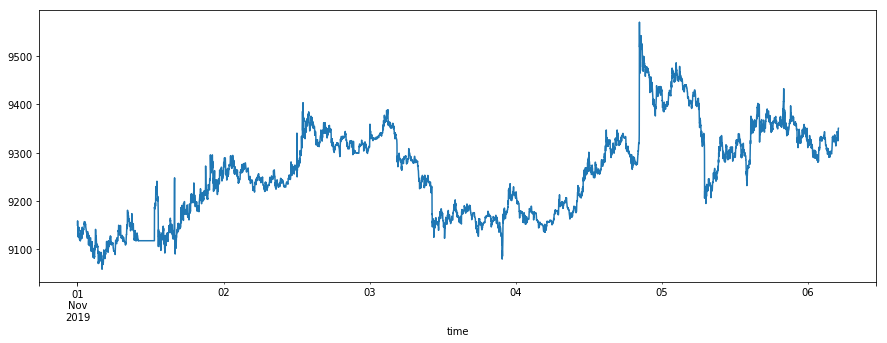

In [228]:
data_MAR_deribit.close.plot(figsize=(15,5))

In [231]:
data_MAR_deribit.query('cost==0')

close  cost    high     low    open         symbol  \
time                                                                       
2019-11-01 01:27:00  9136.5     0  9136.5  9136.5  9136.5  BTC-PERPETUAL   
2019-11-01 01:28:00  9136.5     0  9136.5  9136.5  9136.5  BTC-PERPETUAL   
2019-11-01 01:29:00  9136.5     0  9136.5  9136.5  9136.5  BTC-PERPETUAL   
2019-11-01 02:08:00  9124.0     0  9124.0  9124.0  9124.0  BTC-PERPETUAL   
2019-11-01 02:09:00  9124.0     0  9124.0  9124.0  9124.0  BTC-PERPETUAL   
2019-11-01 02:34:00  9088.0     0  9088.0  9088.0  9088.0  BTC-PERPETUAL   
2019-11-01 02:43:00  9094.5     0  9094.5  9094.5  9094.5  BTC-PERPETUAL   
2019-11-01 04:08:00  9077.5     0  9077.5  9077.5  9077.5  BTC-PERPETUAL   
2019-11-01 06:17:00  9119.0     0  9119.0  9119.0  9119.0  BTC-PERPETUAL   
2019-11-01 06:25:00  9112.0     0  9112.0  9112.0  9112.0  BTC-PERPETUAL   
2019-11-01 06:36:00  9118.0     0  9118.0  9118.0  9118.0  BTC-PERPETUAL   
2019-11-01 06:44:00  9138.5     0  9138.5  9138.5  9138.5  BTC-PERPETUAL   
2019-11-01 07:13:00  9124.0     0  9124.0  9124.0  9124.0  BTC-PERPETUAL   
2019-11-01 07:14:00  9124.0     0  9124.0  9124.0  9124.0  BTC-PERPETUAL   
2019-11-01 07:15:00  9124.0     0  9124.0  9124.0  9124.0  BTC-PERPETUAL   
2019-11-01 07:16:00  9124.0     0  9124.0  9124.0  9124.0  BTC-PERPETUAL   
2019-11-01 07:22:00  9128.5     0  9128.5  9128.5  9128.5  BTC-PERPETUAL   
2019-11-01 07:46:00  9114.5     0  9114.5  9114.5  9114.5  BTC-PERPETUAL   
2019-11-01 07:47:00  9114.5     0  9114.5  9114.5  9114.5  BTC-PERPETUAL   
2019-11-01 07:49:00  9114.5     0  9114.5  9114.5  9114.5  BTC-PERPETUAL   
2019-11-01 07:50:00  9114.5     0  9114.5  9114.5  9114.5  BTC-PERPETUAL   
2019-11-01 08:27:00  9158.0     0  9158.0  9158.0  9158.0  BTC-PERPETUAL   
2019-11-01 08:33:00  9149.0     0  9149.0  9149.0  9149.0  BTC-PERPETUAL   
2019-11-01 08:41:00  9150.5     0  9150.5  9150.5  9150.5  BTC-PERPETUAL   
2019-11-01 09:15:00  9138.0     0  9138.0  9138.0  9138.0  BTC-PERPETUAL   
2019-11-01 09:33:00  9124.0     0  9124.0  9124.0  9124.0  BTC-PERPETUAL   
2019-11-01 09:51:00  9128.5     0  9128.5  9128.5  9128.5  BTC-PERPETUAL   
2019-11-01 10:02:00  9118.0     0  9118.0  9118.0  9118.0  BTC-PERPETUAL   
2019-11-01 10:03:00  9118.0     0  9118.0  9118.0  9118.0  BTC-PERPETUAL   
2019-11-01 10:04:00  9118.0     0  9118.0  9118.0  9118.0  BTC-PERPETUAL   
...                     ...   ...     ...     ...     ...            ...   
2019-11-05 14:21:00  9282.5     0  9282.5  9282.5  9282.5  BTC-PERPETUAL   
2019-11-05 15:04:00  9355.0     0  9355.0  9355.0  9355.0  BTC-PERPETUAL   
2019-11-05 15:05:00  9355.0     0  9355.0  9355.0  9355.0  BTC-PERPETUAL   
2019-11-05 15:07:00  9346.0     0  9346.0  9346.0  9346.0  BTC-PERPETUAL   
2019-11-05 15:09:00  9346.0     0  9346.0  9346.0  9346.0  BTC-PERPETUAL   
2019-11-05 15:12:00  9357.0     0  9357.0  9357.0  9357.0  BTC-PERPETUAL   
2019-11-05 15:16:00  9364.5     0  9364.5  9364.5  9364.5  BTC-PERPETUAL   
2019-11-05 15:22:00  9356.0     0  9356.0  9356.0  9356.0  BTC-PERPETUAL   
2019-11-05 15:25:00  9353.0     0  9353.0  9353.0  9353.0  BTC-PERPETUAL   
2019-11-05 15:32:00  9360.5     0  9360.5  9360.5  9360.5  BTC-PERPETUAL   
2019-11-05 15:41:00  9393.5     0  9393.5  9393.5  9393.5  BTC-PERPETUAL   
2019-11-05 15:43:00  9392.5     0  9392.5  9392.5  9392.5  BTC-PERPETUAL   
2019-11-05 15:56:00  9376.5     0  9376.5  9376.5  9376.5  BTC-PERPETUAL   
2019-11-05 17:26:00  9375.5     0  9375.5  9375.5  9375.5  BTC-PERPETUAL   
2019-11-05 17:27:00  9375.5     0  9375.5  9375.5  9375.5  BTC-PERPETUAL   
2019-11-05 18:04:00  9353.5     0  9353.5  9353.5  9353.5  BTC-PERPETUAL   
2019-11-05 18:19:00  9362.5     0  9362.5  9362.5  9362.5  BTC-PERPETUAL   
2019-11-05 18:20:00  9362.5     0  9362.5  9362.5  9362.5  BTC-PERPETUAL   
2019-11-05 18:22:00  9363.0     0  9363.0  9363.0  9363.0  BTC-PERPETUAL   
2019-11-05 18:24:00  9362.5     0  9362.5  9362.5  9362.5  BTC-PERPETU

In [478]:
data_MAR_deribit1

close     high      low     open      symbol  \
time                                                                        
2019-07-25 01:48:00+00:00  10212.5  10214.5  10212.5  10214.5  btc27sep19   
2019-07-25 04:57:00+00:00  10168.0  10168.0  10163.5  10164.0  btc27sep19   
2019-07-25 06:59:00+00:00  10194.5  10194.5  10194.5  10194.5  btc27sep19   
2019-07-25 09:06:00+00:00  10193.0  10193.0  10191.0  10191.0  btc27sep19   
2019-07-25 11:13:00+00:00  10179.0  10181.0  10179.0  10181.0  btc27sep19   
...                            ...      ...      ...      ...         ...   
2019-09-26 21:16:00+00:00   8035.0   8036.0   8035.0   8036.0  btc27sep19   
2019-09-26 23:50:00+00:00   8094.5   8094.5   8094.5   8094.5  btc27sep19   
2019-09-27 02:25:00+00:00   7977.5   7981.0   7977.0   7980.0  btc27sep19   
2019-09-27 06:08:00+00:00   8003.0   8003.0   8003.0   8003.0  btc27sep19   
2019-09-27 07:59:00+00:00   8056.5   8056.5   8056.0   8056.0  btc27sep19   

                           volume  
time                               
2019-07-25 01:48:00+00:00      51  
2019-07-25 04:57:00+00:00     254  
2019-07-25 06:59:00+00:00       8  
2019-07-25 09:06:00+00:00       3  
2019-07-25 11:13:00+00:00      33  
...                           ...  
2019-09-26 21:16:00+00:00    1210  
2019-09-26 23:50:00+00:00   10020  
2019-09-27 02:25:00+00:00   53500  
2019-09-27 06:08:00+00:00     200  
2019-09-27 07:59:00+00:00   40000  

[657 rows x 6 columns]

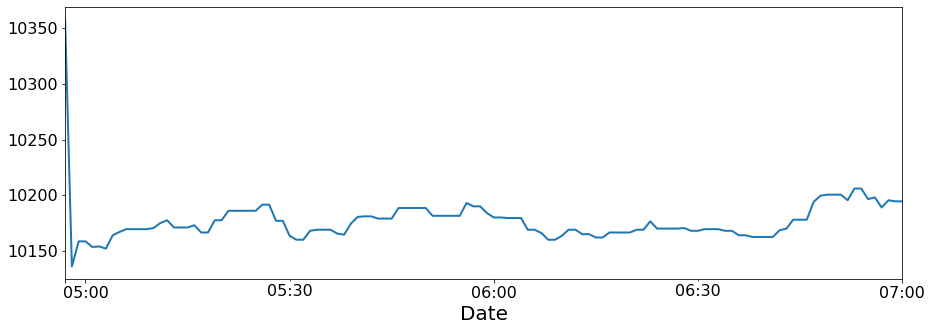

In [477]:
flt = (data_MAR_deribit.index >= '2019-07-25 04:57:00') & (pd.to_datetime(data_MAR_deribit.index) <= '2019-07-25 07:00:00')
ax = data_MAR_deribit['close'][flt].plot(figsize=(15,5))
ax.set_xlabel('Date', fontsize=20)
#ax.set_ylabel('Price ratio of BCH/BTC', fontsize=20)
plt.show()

In [364]:
data_MAR_deribit['macd']

time
2019-09-20 17:04:00+00:00      0.000000
2019-09-20 21:41:00+00:00      0.518519
2019-09-21 07:50:00+00:00     -5.143822
2019-09-21 14:39:00+00:00    -13.789316
2019-09-21 22:01:00+00:00    -20.684910
                                ...    
2019-10-27 18:06:00+00:00    301.887380
2019-10-27 20:09:00+00:00    303.407503
2019-10-27 20:10:00+00:00    302.257656
2019-10-27 22:10:00+00:00    296.994868
2019-10-27 22:12:00+00:00    288.968526
Name: macd, Length: 352, dtype: float64

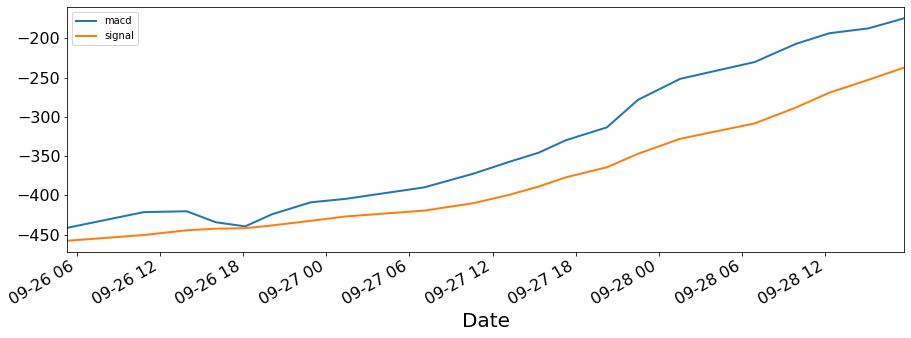

In [401]:
ax = data_MAR_deribit[['macd','signal']][flt].plot(figsize=(15,5))
ax.set_xlabel('Date', fontsize=20)
#ax.set_ylabel('Price ratio of BCH/BTC', fontsize=20)
plt.show()

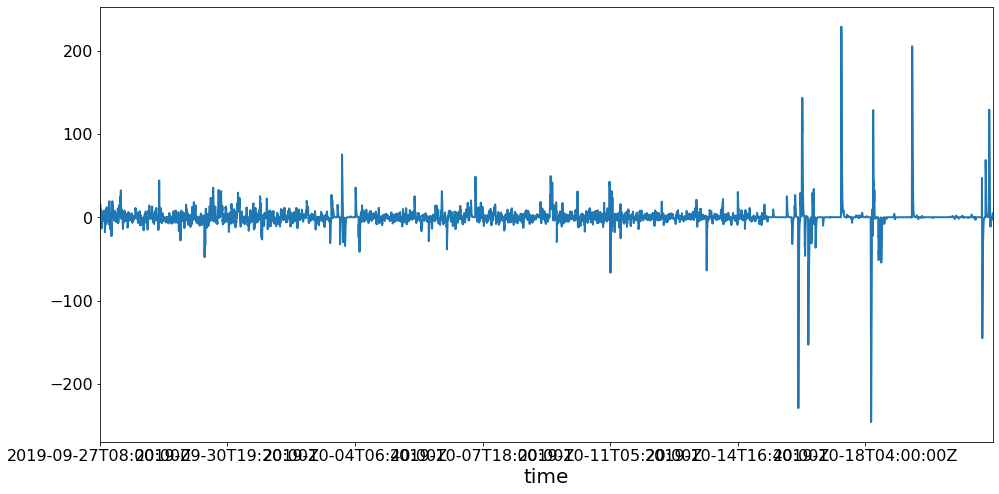

In [76]:
fig, ax = plt.subplots(figsize=(18,5))                    
ax.plot()
ax.plot(np.divide(df.loc[filter_4,'close.18'], df.loc[filter_4,'close.3']))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Price ratio of BCH/BTC', fontsize=20)
ax.legend(['Bittrex', 'Kraken'], fontsize = 18)
# Format the x axis
ax.xaxis.set_major_locator(mdates.HourLocator(interval=15))
ax.xaxis.set_major_formatter(DateFormatter("%m/%d-%H:%M"))
plt.show()

### Backtesting - Backtrader

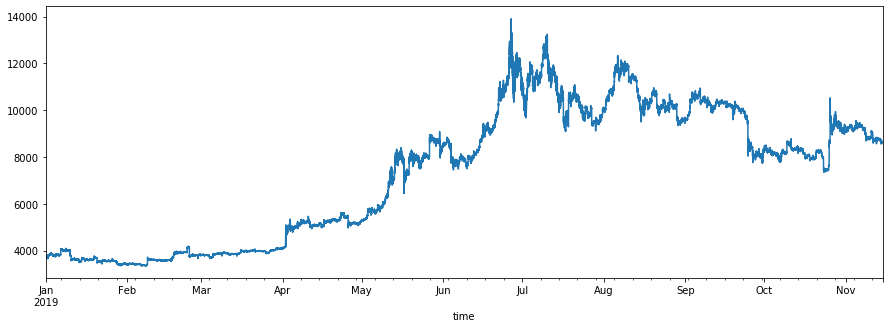

In [7]:
data_1min = influx_client.query("select * from bitmex_1min_trade where symbol='XBTUSD' and time>='2019-01-01 00:00:00' and time<='2019-11-20 00:00:00'")
data_1min = pd.DataFrame(data_1min.get_points())
data_1min.time = pd.to_datetime(data_1min.time)
data_1min.set_index('time', inplace = True)
data_1min.drop(columns='volume',inplace=True)
data_1min.rename(columns={'cost':'volume'}, inplace=True)
data_1H = data_1min.resample('H',label='right').bfill()
data_1min.close.plot(figsize = (15,5))
plt.show()

In [22]:
data_1min

close  foreignNotional    high  homeNotional  lastSize  \
time                                                                           
2019-01-01 16:39:00  3688.5            18085  3688.5      4.903636       200   
2019-01-02 09:18:00  3792.5           152171  3793.0     40.122792      8000   
2019-01-02 09:19:00  3791.5           798704  3793.0    210.618184     17992   

                        low    open  symbol  trades     turnover       vwap  
time                                                                         
2019-01-01 16:39:00  3688.0  3688.0  XBTUSD      41    490363587  3688.1316  
2019-01-02 09:18:00  3792.5  3792.5  XBTUSD      41   4012279216  3792.7634  
2019-01-02 09:19:00  3791.5  3792.5  XBTUSD     271  21061818426  3792.3319

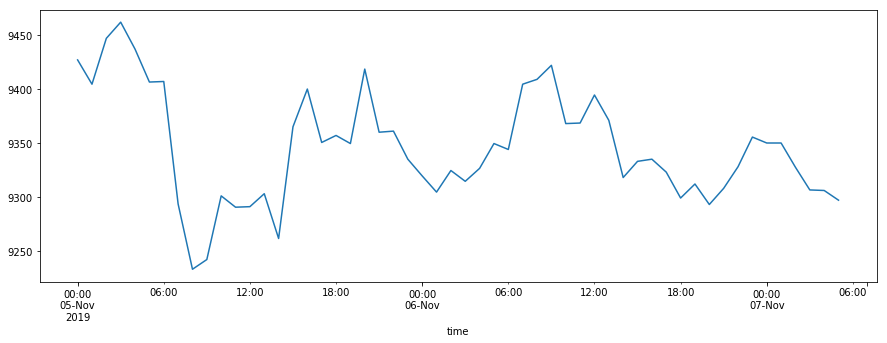

In [100]:
data_1min = influx_client.query("select * from deribit_1min_quote where symbol='BTC-PERPETUAL' and time>='2019-11-05 00:00:00' and time<='2019-11-07 10:00:00'")
data_1min = pd.DataFrame(data_1min.get_points())
data_1min.time = pd.to_datetime(data_1min.time)
data_1min.set_index('time', inplace = True)
data_1min.drop(columns='volume',inplace=True)
data_1min.rename(columns={'cost':'volume'}, inplace=True)
data_1H = data_1min.resample('H',label='right').bfill()
data_1H.close.plot(figsize = (15,5))
plt.show()

In [276]:
data_1min.tail()

close   volume    high     low    open         symbol
time                                                                       
2019-11-06 04:56:00  9340.0   443140  9340.0  9327.5  9327.5  BTC-PERPETUAL
2019-11-06 04:57:00  9346.5  1047360  9346.5  9337.5  9338.0  BTC-PERPETUAL
2019-11-06 04:58:00  9350.0   309080  9350.5  9346.0  9346.5  BTC-PERPETUAL
2019-11-06 04:59:00  9350.5    39850  9350.5  9350.0  9350.0  BTC-PERPETUAL
2019-11-06 05:00:00  9349.5   102610  9350.5  9349.5  9350.5  BTC-PERPETUAL

[[<Figure size 1440x1080 with 8 Axes>]]

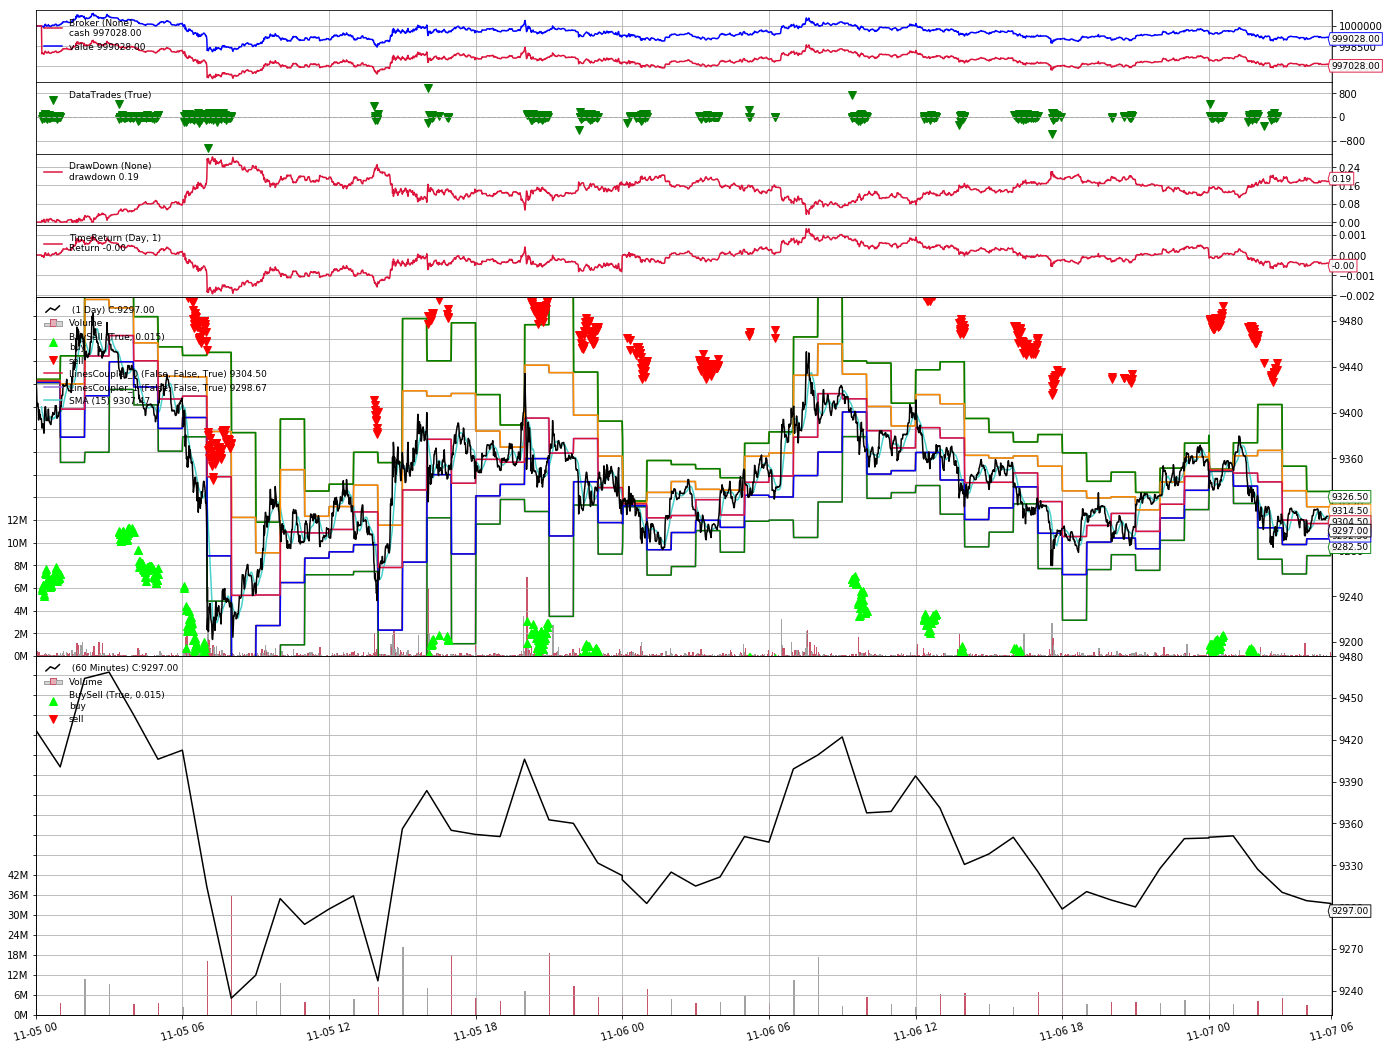

In [107]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import argparse
import datetime

# The above could be sent to an independent module
import backtrader as bt
import backtrader.feeds as btfeeds
import backtrader.indicators as btind
from backtrader.analyzers import (SQN, AnnualReturn, TimeReturn, SharpeRatio,DrawDown,
                                  TradeAnalyzer, SharpeRatio_A, Returns)


class TestStrategy(bt.Strategy):
    '''This strategy buys/sells upong the close price crossing
    upwards/downwards a Simple Moving Average.
    It can be a long-only strategy by setting the param "onlylong" to True
    '''
    lines = ('macd','sig')
    params = dict(
        period_fast=26,
        period_slow=12,
        period=15,
        stake=1,
        printout=False,
        onlylong=False,
        csvcross=False,
    )

    def start(self):
        pass

    def stop(self):
        pass

    def log(self, txt, dt=None):
        if self.p.printout:
            dt = dt or self.data.datetime[0]
            dt = bt.num2date(dt)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # To control operation entries
        self.orderid = None
        
        # [1] SMA
        #self.pp = pp = btind.PivotPoint(self.data1) # data1 has larger interval
        #pp.plotinfo.plot = False  # deactivate plotting
        #pp1 = self.pp()  # couple the entire indicators
        sma = btind.MovAv.SMA(self.data, period=self.p.period, subplot=False)
        #self.signal = self.data0.close < pp.s1()
        self.signal = btind.CrossOver(self.data1.close, sma)
#         self.signal.csv = self.p.csvcross
        
        # [2] MACD
#         fast_ma = btind.MovAv.EMA(self.data, period=self.p.period_fast)
#         slow_ma = btind.MovAv.EMA(self.data, period=self.p.period_slow)
#         self.lines.macd = fast_ma - slow_ma
#         self.lines.sig = btind.MovAv.EMA(self.lines.macd, period = 9)
#         self.signal = btind.CrossOver(self.lines.macd, self.lines.sig)
        #self.signal.csv = self.p.csvcross
        #LinePlotterIndicator(sig, name='Signal)
        
#     def next(self):
#         if self.order:
#             # An order is pending ... nothing can be done
#             return

#         # Check if we are in the market
#         if self.position:
#             # In the maerket - check if it's the time to sell
#             if self.buysell < 0:
#                 self.log('SELL CREATE, %.2f' % self.data.close[0])
#                 self.sell()

#         elif self.buysell > 0:
#             if self.p.valid:
#                 valid = self.data.datetime.date(0) + \
#                         datetime.timedelta(days=self.p.valid)
#             else:
#                 valid = None

#             # Not in the market and signal to buy
#             if self.p.exectype == 'Market':
#                 self.buy(exectype=bt.Order.Market)  # default if not given

#                 self.log('BUY CREATE, exectype Market, price %.2f' %
#                          self.data.close[0])

#             elif self.p.exectype == 'Close':
#                 self.buy(exectype=bt.Order.Close)

#                 self.log('BUY CREATE, exectype Close, price %.2f' %
#                          self.data.close[0])

#             elif self.p.exectype == 'Limit':
#                 price = self.data.close * (1.0 - self.p.perc1 / 100.0)

#                 self.buy(exectype=bt.Order.Limit, price=price, valid=valid)

#                 if self.p.valid:
#                     txt = 'BUY CREATE, exectype Limit, price %.2f, valid: %s'
#                     self.log(txt % (price, valid.strftime('%Y-%m-%d')))
#                 else:
#                     txt = 'BUY CREATE, exectype Limit, price %.2f'
#                     self.log(txt % price)

#             elif self.p.exectype == 'Stop':
#                 price = self.data.close * (1.0 + self.p.perc1 / 100.0)

#                 self.buy(exectype=bt.Order.Stop, price=price, valid=valid)

#                 if self.p.valid:
#                     txt = 'BUY CREATE, exectype Stop, price %.2f, valid: %s'
#                     self.log(txt % (price, valid.strftime('%Y-%m-%d')))
#                 else:
#                     txt = 'BUY CREATE, exectype Stop, price %.2f'
#                     self.log(txt % price)

#             elif self.p.exectype == 'StopLimit':
#                 price = self.data.close * (1.0 + self.p.perc1 / 100.0)

#                 plimit = self.data.close * (1.0 + self.p.perc2 / 100.0)

#                 self.buy(exectype=bt.Order.StopLimit, price=price, valid=valid,
#                          plimit=plimit)

#                 if self.p.valid:
#                     txt = ('BUY CREATE, exectype StopLimit, price %.2f,'
#                            ' valid: %s, pricelimit: %.2f')
#                     self.log(txt % (price, valid.strftime('%Y-%m-%d'), plimit))
#                 else:
#                     txt = ('BUY CREATE, exectype StopLimit, price %.2f,'
#                            ' pricelimit: %.2f')
#                     self.log(txt % (price, plimit))

        

    def next(self):
        if self.orderid:
            return  # if an order is active, no new orders are allowed

        if self.signal > 0.0:  # cross upwards
            if self.position:
                self.log('CLOSE SHORT , %.2f' % self.data1.close[0])
                self.close()

            self.log('BUY CREATE , %.2f; value = %.2f' % (self.data1.close[0],cerebro.broker.getvalue()))
            self.buy(size=self.p.stake)
#             self.buy(exectype=bt.Order.Limit,
#                      price=self.data.close[0]*1.02, 
#                      plimit=self.data.close[0]*1.07)

        elif self.signal < 0.0:
            if self.position:
                self.log('CLOSE LONG , %.2f; value = %.2f' % (self.data1.close[0], cerebro.broker.getvalue()))
                self.close()

            if not self.p.onlylong:
                self.log('SELL CREATE , %.2f' % self.data1.close[0])
                self.sell(size=self.p.stake)

    def notify_order(self, order):
        if order.status in [bt.Order.Submitted, bt.Order.Accepted]:
            return  # Await further notifications

        if order.status == order.Completed:
            if order.isbuy():
                buytxt = 'BUY COMPLETE, %.2f' % order.executed.price
                self.log(buytxt, order.executed.dt)
            else:
                selltxt = 'SELL COMPLETE, %.2f' % order.executed.price
                self.log(selltxt, order.executed.dt)

        elif order.status in [order.Expired, order.Canceled, order.Margin]:
            self.log('%s ,' % order.Status[order.status])
            pass  # Simply log

        # Allow new orders
        self.orderid = None

    def notify_trade(self, trade):
        if trade.isclosed:
            self.log('TRADE PROFIT, GROSS %.2f, NET %.2f' %
                     (trade.pnl, trade.pnlcomm))

        elif trade.justopened:
            self.log('TRADE OPENED, SIZE %2d' % trade.size)


def parse_args():
    parser = argparse.ArgumentParser(description='TimeReturn')

    parser.add_argument('--data', '-d',
                        default='../../datas/2005-2006-day-001.txt',
                        help='data to add to the system')

    parser.add_argument('--fromdate', '-f',
                        default='2005-01-01',
                        help='Starting date in YYYY-MM-DD format')

    parser.add_argument('--todate', '-t',
                        default='2006-12-31',
                        help='Starting date in YYYY-MM-DD format')

    parser.add_argument('--period', default=15, type=int,
                        help='Period to apply to the Simple Moving Average')
    
    parser.add_argument('--period_slow', default=26, type=int,
                    help='Period to apply to the Simple Moving Average')
    
    parser.add_argument('--period_fast', default=12, type=int,
                    help='Period to apply to the Simple Moving Average')

    parser.add_argument('--onlylong', '-ol', default=True, action='store_false',
                        help='Do only long operations')

    parser.add_argument('--writercsv', '-wcsv', action='store_true',
                        help='Tell the writer to produce a csv stream')

    parser.add_argument('--csvcross', action='store_true',
                        help='Output the CrossOver signals to CSV')

    group = parser.add_mutually_exclusive_group()
    group.add_argument('--tframe', default='days', required=False,
                       choices=['days', 'weeks', 'months', 'years'],
                       help='TimeFrame for the returns/Sharpe calculations')

    group.add_argument('--legacyannual', action='store_true',
                       help='Use legacy annual return analyzer')

    parser.add_argument('--cash', default=1000000, type=int,
                        help='Starting Cash')

    parser.add_argument('--comm', default=2, type=float,
                        help='Commission for operation')

    parser.add_argument('--mult', default=10, type=int,
                        help='Multiplier for futures')

    parser.add_argument('--margin', default=2000.0, type=float,
                        help='Margin for each future')

    parser.add_argument('--stake', default=1, type=int,
                        help='Stake to apply in each operation')

    parser.add_argument('--plot', '-p', action='store_true',
                        help='Plot the read data')

    parser.add_argument('--numfigs', '-n', default=1,
                        help='Plot using numfigs figures')

    return parser.parse_args()


#####################################################################
#RUN
#####################################################################
args = parse_args()

# Create a cerebro
cerebro = bt.Cerebro()

# Get the dates from the args
#fromdate = datetime.datetime.strptime(args.fromdate, '%Y-%m-%d')
#todate = datetime.datetime.strptime(args.todate, '%Y-%m-%d')

# Create the 1st data
#     data = btfeeds.BacktraderCSVData(
#         dataname=args.data,
#         fromdate=fromdate,
#         todate=todate)
data = bt.feeds.PandasData(dataname = data_1min)

# Add the 1st data to cerebro
cerebro.adddata(data)
cerebro.resampledata(data, timeframe=bt.TimeFrame.Minutes, compression=60)

# Add the strategy
cerebro.addstrategy(TestStrategy)
                    #period_fast=args.period_fast,
                    #period_slow=args.period_slow,
                    #onlylong=args.onlylong,
                    #csvcross=args.csvcross,
                    #stake=args.stake)

# define the size
#cerebro.addsizer(bt.sizers.PercentSizer, stake=20) 

# Add the commission - only stocks like a for each operation
#cerebro.broker.setcash(args.cash)
cerebro.broker.setcash(1000000)

# Add the commission - only stocks like a for each operation
cerebro.broker.setcommission(commission=0.0015,
                             mult=10,
                             margin=2000)

tframes = dict(
    days=bt.TimeFrame.Days,
    weeks=bt.TimeFrame.Weeks,
    months=bt.TimeFrame.Months,
    years=bt.TimeFrame.Years)

# Add the Analyzers
#cerebro.addanalyzer(SQN)
cerebro.addanalyzer(AnnualReturn)
#     if args.legacyannual:
#         cerebro.addanalyzer(SharpeRatio, legacyannual=True)
#     else:
    #cerebro.addanalyzer(TimeReturn, timeframe=tframes[args.tframe])
cerebro.addanalyzer(SharpeRatio_A, timeframe=bt.TimeFrame.Days)
cerebro.addanalyzer(Returns)
cerebro.addanalyzer(DrawDown)
#cerebro.addanalyzer(TimeReturn)
cerebro.addanalyzer(TradeAnalyzer)

cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn, timeframe=bt.TimeFrame.Days)


#cerebro.addwriter(bt.WriterFile, csv=args.writercsv, rounding=4)

# And run it
results = cerebro.run()
strat = results[0]

# Plot if requested
#if args.plot:
#    cerebro.plot(numfigs=args.numfigs, volume=False, zdown=False)

plt.rcParams['figure.figsize'] = 20,15
cerebro.plot(iplot=False, style='line')

In [106]:
for x in strat.analyzers:
    x.print()

AnnualReturn:
  - 2019: -0.0018900225000001436
SharpeRatio_A:
  - sharperatio: -25.065068277258312
Returns:
  - rtot: -0.0018918108462237279
  - ravg: -0.0006306036154079093
  - rnorm: -0.14692866880993188
  - rnorm100: -14.692866880993188
DrawDown:
  - len: 33
  - drawdown: 0.22342501870370302
  - moneydown: 2235.0210000001825
  -----------------------------------------------------------------------------
  - max:
    - len: 33
    - drawdown: 0.23292174234829072
    - moneydown: 2330.0210000001825
TradeAnalyzer:
  -----------------------------------------------------------------------------
  - total:
    - total: 8
    - open: 1
    - closed: 7
  -----------------------------------------------------------------------------
  - streak:
    +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    - won:
      - current: 0
      - longest: 1
    +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    - lost:
      - current: 4
      - long

In [23]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)


import argparse
import datetime
import random

import backtrader as bt


class St(bt.Strategy):
    params = (
        ('printout', False),
        ('stake', 1000),
    )

    def __init__(self):
        pass

    def start(self):
        if self.p.printout:
            txtfields = list()
            txtfields.append('Len')
            txtfields.append('Datetime')
            txtfields.append('Open')
            txtfields.append('High')
            txtfields.append('Low')
            txtfields.append('Close')
            txtfields.append('Volume')
           # txtfields.append('OpenInterest')
            print(','.join(txtfields))

    def next(self):
        if self.p.printout:
            # Print only 1st data ... is just a check that things are running
            txtfields = list()
            txtfields.append('%04d' % len(self))
            txtfields.append(self.data0.datetime.datetime(0).isoformat())
            txtfields.append('%.2f' % self.data0.open[0])
            txtfields.append('%.2f' % self.data0.high[0])
            txtfields.append('%.2f' % self.data0.low[0])
            txtfields.append('%.2f' % self.data0.close[0])
            txtfields.append('%.2f' % self.data0.volume[0])
            #txtfields.append('%.2f' % self.data0.openinterest[0])
            print(','.join(txtfields))

        # Data 0
        for data in self.datas:
            toss = random.randint(1, 10)
            curpos = self.getposition(data)
            if curpos.size:
                if toss > 5:
                    size = curpos.size // 2
                    self.sell(data=data, size=size)
                    if self.p.printout:
                        print('SELL {} @%{}'.format(size, data.close[0]))

            elif toss < 5:
                self.buy(data=data, size=self.p.stake)
                if self.p.printout:
                    print('BUY  {} @%{}'.format(self.p.stake, data.close[0]))


def runstrat(args=None):
    args = parse_args(args)

    cerebro = bt.Cerebro()
    cerebro.broker.set_cash(args.cash)

    dkwargs = dict()
    if args.fromdate:
        fromdate = datetime.datetime.strptime(args.fromdate, '%Y-%m-%d %H:%M:%S')
        dkwargs['fromdate'] = fromdate

    if args.todate:
        todate = datetime.datetime.strptime(args.todate, '%Y-%m-%d %H:%M:%S')
        dkwargs['todate'] = todate

    data0 = bt.feeds.PandasData(dataname=data_1min)

#     data1 = bt.feeds.BacktraderCSVData(dataname=args.data1, **dkwargs)
#     cerebro.adddata(data1, name='Data1')

#     data2 = bt.feeds.BacktraderCSVData(dataname=args.data2, **dkwargs)
#     cerebro.adddata(data2, name='Data2')

    cerebro.addstrategy(St, printout=args.printout)
    if not args.no_pyfolio:
        cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

    results = cerebro.run()
    if not args.no_pyfolio:
        strat = results[0]
        pyfoliozer = strat.analyzers.getbyname('pyfolio')

        returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
        if args.printout:
            print('-- RETURNS')
            print(returns)
            print('-- POSITIONS')
            print(positions)
            print('-- TRANSACTIONS')
            print(transactions)
            print('-- GROSS LEVERAGE')
            print(gross_lev)

        import pyfolio as pf
        pf.create_full_tear_sheet(
            returns,
            positions=positions,
            transactions=transactions,
            gross_lev=gross_lev,
            live_start_date='2019-10-20',
            round_trips=True)

    if args.plot:
        cerebro.plot(style=args.plot_style)


def parse_args(args=None):

    parser = argparse.ArgumentParser(
        formatter_class=argparse.ArgumentDefaultsHelpFormatter,
        description='Sample for pivot point and cross plotting')

#     parser.add_argument('--data0', required=False,
#                         default='../../datas/yhoo-1996-2015.txt',
#                         help='Data to be read in')

#     parser.add_argument('--data1', required=False,
#                         default='../../datas/orcl-1995-2014.txt',
#                         help='Data to be read in')

#     parser.add_argument('--data2', required=False,
#                         default='../../datas/nvda-1999-2014.txt',
#                         help='Data to be read in')

    parser.add_argument('--fromdate', required=False,
                        default='2019-09-20 00:00:00',
                        help='Starting date in YYYY-MM-DD format')

    parser.add_argument('--todate', required=False,
                        default='2019-11-04 00:00:00',
                        help='Ending date in YYYY-MM-DD format')

    parser.add_argument('--printout', required=False, action='store_true',
                        help=('Print data lines'))

    parser.add_argument('--cash', required=False, action='store',
                        type=float, default=1000000,
                        help=('Cash to start with'))

    parser.add_argument('--plot', required=False, action='store_true',
                        help=('Plot the result'))

    parser.add_argument('--plot-style', required=False, action='store',
                        default='bar', choices=['bar', 'candle', 'line'],
                        help=('Plot style'))

    parser.add_argument('--no-pyfolio', required=False, action='store_true',
                        help=('Do not do pyfolio things'))

    import sys
    aargs = args if args is not None else sys.argv[1:]
    return parser.parse_args(aargs)
runstrat([])

IndexError: list index out of range

In [64]:
import inspect
import os
print(os.path.abspath(inspect.getfile(bt.DataResampler)))

AttributeError: module 'backtrader' has no attribute 'DataResampler'

In [ ]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import os.path
import argparse
import datetime

import backtrader as bt
import backtrader.feeds as btfeeds
import backtrader.plot as plt
import backtrader.indicators as btinds

class EMA(btinds.PeriodN):
    lines = ('signal1','signal2')
    params = (('p1',5),('p2',20),('p3',50),)
    
    def __init__(self):
        ema5 = btinds.ExponentialMovingAverage(self.data.close, period=self.p.p1)
        ema20 = btinds.ExponentialMovingAverage(self.data.close, period=self.p.p2)
        ema50 = btinds.ExponentialMovingAverage(self.data.close,period=self.p.p3)
        self.lines.signal1 = ema5-ema20
        self.lines.signal2 = ema20-ema50

class St(bt.Strategy):
    
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.data0.datetime.date(0)
        dt1 = self.data0.datetime.time(0)
        print('%s,%s, %s' % (dt.isoformat(),dt1.isoformat(), txt))
        
    def __init__(self):
        self.trigger = EMA()
        self.spread = btinds.AverageTrueRange(period=20)
        
    def notify_order(self, order):
        print('{} {}: Order ref: {} / Type {} / Status {}'.format(
            self.data.datetime.date(0),self.data.datetime.time(0),
            order.ref, 'Buy' * order.isbuy() or 'Sell',
            order.getstatusname()))
        
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Ref: %d, Price: %.5f, Cost: %.5f' %
                    (order.ref,order.executed.price,
                     order.executed.value))
                
                self.buyprice = order.executed.price
                
            else:  # Sell
                self.log('SELL EXECUTED, Ref: %d,Price: %.5f, Cost: %.5f' %
                         (order.ref,order.executed.price,
                          order.executed.value))
        
            self.bar_executed = len(self)
            
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
        
        if not order.alive() and order.ref in self.orefs:
            self.orefs.remove(order.ref)
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.5f, NET %.5f' %
                 (trade.pnl, trade.pnlcomm))
        
    def next(self):
        txt = ','.join(
            ['%04d' % len(self.data0),
             self.data0.datetime.date(0).isoformat(),
             self.data0.datetime.time(0).isoformat(),
             'Open : %.5f' % self.data0.open[0],
             'High : %.5f' % self.data.high[0],
             'Low : %.5f' % self.data.low[0],
             'Close : %.5f' % self.data.close[0]]) 
        print(txt)
 

        if (self.trigger.signal1[0] > 0) and (self.trigger.signal2[0] > 0):
             o1 = self.sell(exectype = bt.Order.Limit,price=self.data.close[-1],
                            transmit=False,valid=datetime.datetime.now()+datetime.timedelta(hours=1))
             
             print(self.datetime.date(0),self.datetime.time(0),' : Oref %d / Sell at %.5f' % (
                        o1.ref, self.data.close[-1]))
            
             o2 = self.buy(exectype=bt.Order.Limit,price=(self.data.close[-1] - self.spread.atr[0] * 2),
                            parent=o1,transmit=False)
             
             print(self.datetime.date(0),self.datetime.time(0),' : Oref %d / Sell Take Profit at %.5f' % (
                        o2.ref, (self.data.close[-1] - self.spread.atr[0] * 2)))
             
             o3 = self.buy(exectype=bt.Order.Stop,price = (self.spread.atr[0] * 2 +self.data.close[-1]),
                           parent=o1,transmit = True)
             
             print(self.datetime.date(0),self.datetime.time(0),' : Oref %d / Sell Stop Loss at %.5f' % (
                        o3.ref, (self.spread.atr[0] * 2 +self.data.close[-1])))
             
             self.orefs = [o1.ref, o2.ref, o3.ref]
             
        elif (self.trigger.signal1[0] < 0) and (self.trigger.signal2[0] < 0):
             o1 = self.buy(exectype = bt.Order.Limit,price=self.data.close[-1],
                            transmit=False,valid= datetime.datetime.now()+datetime.timedelta(hours=1))
             
             print(self.datetime.date(0),self.datetime.time(0),' : Oref %d / Buy at %.5f' % (
                        o1.ref, self.data.close[-1]))
            
             o2 = self.sell(exectype=bt.Order.Limit,price=(self.spread.atr[0] * 2 +self.data.close[-1]),
                            parent=o1,transmit=False)
             
             print(self.datetime.date(0),self.datetime.time(0),' : Oref %d / Buy Take Profit at %.5f' % (
                        o2.ref, (self.spread.atr[0] * 2 +self.data.close[-1])))
             
             o3 = self.sell(exectype=bt.Order.Stop,price = (self.data.close[-1] - self.spread.atr[0] * 2),
                           parent=o1,transmit = True)
             
             print(self.datetime.date(0),self.datetime.time(0),' : Oref %d / Buy Stop Loss at %.5f' % (
                        o3.ref, (self.data.close[-1] - self.spread.atr[0] * 2))) 
             
             self.orefs = [o1.ref, o2.ref, o3.ref]
        
        else:
             return



class Plotter(plt.Plot):

    def __init__(self):
        super().__init__(volup='#60cc73')  # custom color for volume up bars 

    def show(self):
        mng = self.mpyplot.get_current_fig_manager()
        mng.window.state('zoomed')
        self.mpyplot.show()  
                  
def runstrat():
    args = parse_args()

    cerebro = bt.Cerebro()
#     modpath = 'd:\\I - TradersGPS\\'
#     datapath0 = os.path.join(modpath, 'GBPUSD_H1_UTC+2_00.csv')
   
#     data0 = btfeeds.GenericCSVData(dataname=datapath0,
#                                    timeframe=bt.TimeFrame.Minutes,
#                                   fromdate = datetime.datetime(2017,3,15),
#                                   todate=datetime.datetime(2017,3,20),                                  
#                                   nullvalue=0.0,
#                                   dtformat=('%Y.%m.%d'),
#                                   tmformat=('%H:%M'),
#                                   datetime=0,
#                                   time=1,
#                                   open=2,
#                                   high=3,
#                                   low=4,
#                                   close=5,
#                                   volume=6,
#                                   openinterest=-1)

    cerebro.adddata(data)


    cerebro.addstrategy(St)
    cerebro.broker.setcash(100000.0)
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run(stdstats=False)
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    plotter = Plotter()
    cerebro.plot(plotter=plotter,subplot=False)
    

        
def parse_args():
    parser = argparse.ArgumentParser(
        formatter_class=argparse.ArgumentDefaultsHelpFormatter,
        description='Sample for pivot point and cross plotting')

    parser.add_argument('--data0',
                        default='d:\\I - TradersGPS\\GBPUSD_D1_UTC+2_00.csv',
                        required=False, help='Data0 to read in')

    parser.add_argument('--data1', 
                        default='d:\\I - TradersGPS\\GBPUSD_H1_UTC+2_00.csv',
                        required=False, help='Data1 to read in')

    parser.add_argument('--fromdate', required=False, default='2001-01-01',
                        help='Date[time] in YYYY-MM-DD[THH:MM:SS] format')
    
    parser.add_argument('--todate', required=False, default='2007-01-01',
                        help='Date[time] in YYYY-MM-DD[THH:MM:SS] format')

    parser.add_argument('--plot', required=False, action='store_true',
                        help=('Plot the result'))

    return parser.parse_args()


if __name__ == '__main__':
    runstrat()

### Volatility

In [ ]:
self.log_return = np.log(self.series/self.series.shift(1))
self.log_return.dropna(inplace=True)
self.realized_vol = np.square(self.log_return).resample('1D').agg('sum')

In [178]:
def ewVol(self,hl_days):
    variances = self.realized_vol.values
    returns = self.log_return.values
    prevVar = variances[0]
    ewVarL = [prevVar]
    oneDecay = 2.0**(-1.0/hl_days*self.period)       # standard oldvar weight
    oneNew = 1.0 - oneDecay           # standard new var weight
    for c in range(len(variances)):
        newWeight = oneNew/(1-oneDecay**(c+1))    # approaches oneNew
        newVar = variances[c]
        blendVar = newVar * newWeight + prevVar * (1.0 -  newWeight)
        ewVarL.append(blendVar)
        prevVar = blendVar
    return np.sqrt(ewVarL) # return volatility

In [203]:
# Get percentage of ranking in the back rolling window for the current data
import scipy.stats as stats
def quantile(series, roll_win=100):
    rank_perc = lambda x: stats.percentileofscore(x, x[-1])        
    return series.rolling(roll_win).apply(rank_perc).dropna()